construct lesion graph from an ICA image 

In [34]:
import numpy as np
import matplotlib.pyplot as plt 
import igraph as ig
import torch
import numpy as np
import cv2
from sklearn.metrics import pairwise_distances
from tqdm import tqdm
from torch_geometric.data import Data, DataLoader
import pandas as pd
from scipy.spatial import Delaunay
from skimage.morphology import skeletonize
import os
from typing import List, Tuple


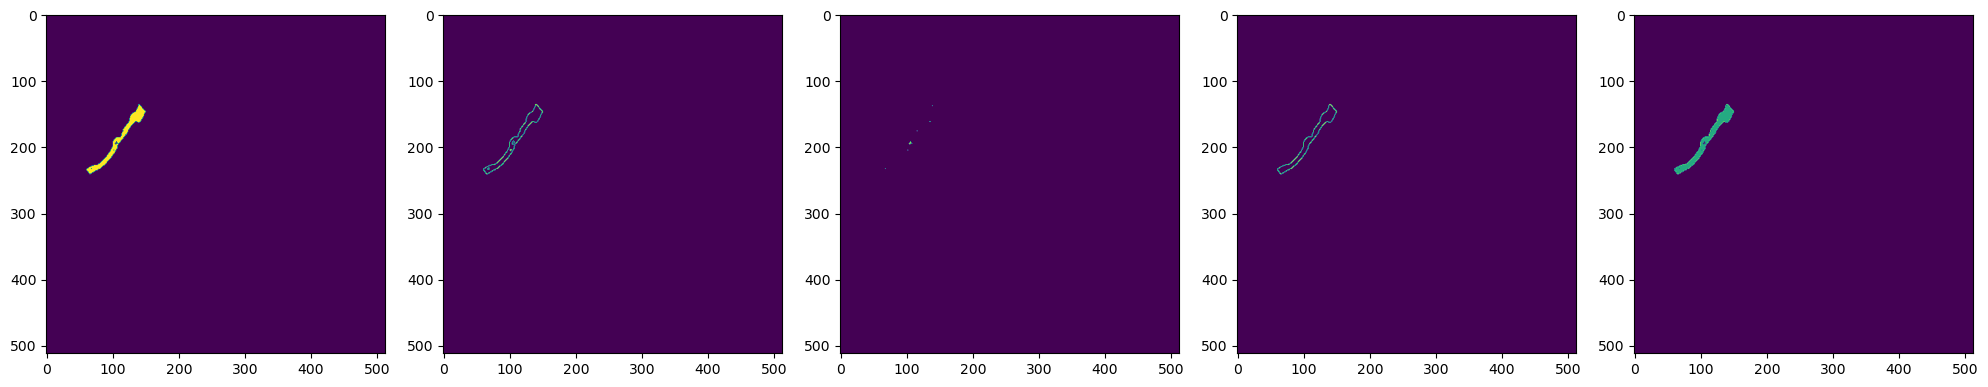

In [35]:
img_path = "/home/sun/data//FAME2labelling/01-0002/17-RAO30.4-CRA07.5/RCA/raw.tif"
lesion_mask_path = "/home/sun/data//FAME2labelling/01-0002/17-RAO30.4-CRA07.5/RCA/lesion2-labelled.tif"
arerty_mask_path = "/home/sun/data//FAME2labelling/01-0002/17-RAO30.4-CRA07.5/RCA/labelled.tif"

#read img and mask 
raw_img = plt.imread(img_path)
artery_mask_img = plt.imread(lesion_mask_path)

lesion_mask_img = plt.imread(lesion_mask_path)

f, ax = plt.subplots(1,5, figsize=(20,10))

mask = lesion_mask_img.astype(np.uint8)

# get edges
lesion = lesion_mask_img.astype(np.uint8)
lesion[lesion == 1] = 0 # kill the artery segmentation
edges = cv2.Canny(mask, 1,2)

# may need to close holes
kernelSize = (3,3)  
kernel = cv2.getStructuringElement(cv2.MORPH_RECT, kernelSize)
closing = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel)
edges_after_close = cv2.Canny(closing, 1,2)

# Try to get pixels in the edges 
ax[0].imshow(mask)
ax[1].imshow(edges)
ax[2].imshow(closing - mask)
ax[3].imshow(edges_after_close)
ax[4].imshow(edges_after_close + 100 * lesion)

f.tight_layout()
plt.show()

In [36]:
def extract_edges(artery_mask, artery_w_lesion_mask, raw_img, centerline_mask) -> Tuple[torch.Tensor, torch.Tensor, torch.Tensor]:
    '''
    Input
    ---
    * `artery_mask`:

    Output
    ---
    List with (x,y) and features and the edge mask for later processing
    '''
    # if self.extract_lesion_points_only:
    #         # Restrict to only lesion pixels
    #     lesion_pixels_mask = artery_w_lesion_mask == 2
    #     artery_mask.fill(0)
    #     artery_mask[lesion_pixels_mask] = 1

    # Get edges
    edge_mask = cv2.Canny(artery_mask, 1, 2)
    coordinates = np.vstack(np.where(edge_mask != 0)).transpose(1,0)
    lesion_points = (artery_w_lesion_mask[coordinates[:,0], coordinates[:,1]] == 2).astype(np.bool8).reshape(-1)

    # Get features
    pixel_wide_features = []
    pixel_wide_features.append(coordinates)

    # add more features if selected
    # if self.attach_features != None:
    #     pixel_wide_features.extend(self.__get_attached_features(df_info, coordinates, artery_w_lesion_mask, centerline_mask))

    # # Skip the pixel intensity
    # # Always attach pixel intensity last so we can skip it if we want
    # if not self.skip_pixel_intensity:
    pixel_wide_features.append(raw_img[coordinates[:,0], coordinates[:,1]].reshape(-1,1))

    features = np.hstack(pixel_wide_features)

    return coordinates, features, edge_mask, lesion_points
# distance_from_centerline = np.zeros((len(coordinates),1))
# for i, point in enumerate(coordinates):
#     distance_from_centerline[i] = np.min(np.linalg.norm(centerline_coordinates - point.reshape(2,1),axis=0))


In [37]:
def extract_inner(artery_w_lesion_mask, edge_mask, raw_img, centerline_mask) -> Tuple[torch.Tensor, torch.Tensor]:
        '''
        Input:
        ---
        * `artery_mask`:
        Output:
        ---
        inner artery pixels (not concerning lesion pixels)
        '''
        inner_mask = np.copy(artery_w_lesion_mask)

        # Extract only lesion points
        lesion_pixels_mask = artery_w_lesion_mask == 2
        inner_mask.fill(0)
        inner_mask[lesion_pixels_mask] = 1

        # Get inner
        inner_mask[edge_mask != 0] = 0 # Remove edges
        coordinates = np.vstack(np.where(inner_mask != 0)).transpose(1,0)
        lesion_points = (artery_w_lesion_mask[coordinates[:,0], coordinates[:,1]] == 2).astype(np.bool8).reshape(-1)

        # Get features
        pixel_wide_features = []
        pixel_wide_features.append(coordinates)

        # add more features if selected
        # pixel_wide_features.extend(self.__get_attached_features(df_info, coordinates, artery_w_lesion_mask, centerline_mask))

        # Skip the pixel intensity
        # Always attach pixel intensity last so we can skip it if we want
        pixel_wide_features.append(raw_img[coordinates[:,0], coordinates[:,1]].reshape(-1,1))

        features = np.hstack(pixel_wide_features)

        return coordinates, features, lesion_points

In [38]:
#extract centerline, inner node and edge node
centerline_mask = skeletonize(lesion).astype(np.uint8)
centerline_coordinates = np.where(centerline_mask)
centerline_coordinates = np.vstack([centerline_coordinates[0], centerline_coordinates[1]])

edge_coordinates, edge_features, edge_mask, edge_lesion_points \
            = extract_edges(lesion_mask_img, lesion_mask_img,  raw_img, centerline_mask)

inner_coordinates, inner_features, inner_lesion_points \
            = extract_inner(lesion_mask_img, edge_mask, raw_img, centerline_mask)

# coordinates = torch.LongTensor(np.concatenate([inner_coordinates, edge_coordinates]))
# features = torch.FloatTensor(np.concatenate([inner_features, edge_features]))
# lesion_points = torch.BoolTensor(np.concatenate([inner_lesion_points, edge_lesion_points]))
coordinates = np.concatenate([inner_coordinates, edge_coordinates])
features = np.concatenate([inner_features, edge_features])
lesion_points = np.concatenate([inner_lesion_points, edge_lesion_points])
centerline_coordinates = np.where(centerline_mask)
centerline_coordinates = np.vstack([centerline_coordinates[0], centerline_coordinates[1]])

distance_from_centerline = np.zeros((len(coordinates),1))
for i, point in enumerate(coordinates):
    distance_from_centerline[i] = np.min(np.linalg.norm(centerline_coordinates - point.reshape(2,1),axis=0))


features = np.concatenate([features, distance_from_centerline],axis=-1)
print(np.shape(distance_from_centerline))
print(np.shape(features))


(352, 1)
(352, 4)


/tmp/ipykernel_2617220/258028018.py:20: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  lesion_points = (artery_w_lesion_mask[coordinates[:,0], coordinates[:,1]] == 2).astype(np.bool8).reshape(-1)


In [39]:
class VertexConnector:
    def __init__(self) -> None:
        pass

    def connect(self, coordinates: torch.Tensor, features: torch.Tensor) -> torch.tensor:
        ''' Connects vertexes and returns the edges in COO format: [ [v1, v2], ... ].
            The edges should be ready to be used in pytorch geometric's Data class
        '''
        pass
    
class KNNVertexConnector(VertexConnector):
    def __init__(self,k:int) -> None:
        super().__init__()
        self.k = k

    def connect(self, coordinates: torch.Tensor, features: torch.Tensor) -> torch.Tensor:
        coordinate_knn_indexes = self._get_k_nearest_neighbors(coordinates, self.k)
        edge_indexes = self._create_edge_index(coordinate_knn_indexes)

        return edge_indexes

    def _get_k_nearest_neighbors(self, coordinates, k):
        neighbor_idxes = np.zeros((coordinates.shape[0], k), np.int32)
        indices = np.arange(k+1)
        for i, row in enumerate(pairwise_distances(coordinates, n_jobs=8)):
            idxes = np.argpartition(row, k)[:k+1]
            neighbor_idxes[i,:] = idxes[indices != i][:k]
        return neighbor_idxes


    def _create_edge_index(self, coordinate_knn_indexes: torch.Tensor) -> torch.Tensor:
        # Create COO graph
        edge_index = set()
        for i, knn_indexes in enumerate(coordinate_knn_indexes):
            for j in knn_indexes:
                # add both directions
                edge_index.add((i,j))
                edge_index.add((j,i))
        edge_index = torch.tensor(list(edge_index), dtype=torch.long)
        return edge_index

class DelaunayVertexConnector(VertexConnector):
    def __init__(self, distance_cuttoff) -> None:
        super().__init__()
        self.distance_cutoff = distance_cuttoff

    def connect(self, coordinates: torch.Tensor, features: torch.Tensor) -> torch.Tensor:
        triangulation = Delaunay(coordinates)

        return self.to_edges_coo(self.prune_simplices(triangulation, coordinates))


    def prune_simplices(self, triangulation, points):
        idxes_to_keep = []
        cond = lambda di: di > self.distance_cutoff
        for i, row in enumerate(points[triangulation.simplices]):
            bitmap = [0,0,0]
            bitmap[0] = cond(torch.norm((row[0]- row[1]).to(torch.float)))
            bitmap[1] = cond(torch.norm((row[0]- row[2]).to(torch.float)))
            bitmap[2] = cond(torch.norm((row[2]- row[1]).to(torch.float)))
            if sum(bitmap) != 0: continue
            idxes_to_keep.append(i)
        return triangulation.simplices[idxes_to_keep]

    def to_edges_coo(self, simplices):
        edge_indexes = set()
        for tri in simplices:
            edge_indexes.add((tri[0], tri[1]))
            edge_indexes.add((tri[1], tri[0]))
            edge_indexes.add((tri[0], tri[2]))
            edge_indexes.add((tri[2], tri[0]))
            edge_indexes.add((tri[1], tri[2]))
            edge_indexes.add((tri[2], tri[1]))
        return torch.LongTensor(list(edge_indexes))

In [40]:
coordinates = torch.LongTensor(np.concatenate([inner_coordinates, edge_coordinates]))
features = torch.FloatTensor(np.concatenate([inner_features, edge_features]))
lesion_points = torch.BoolTensor(np.concatenate([inner_lesion_points, edge_lesion_points]))

vertex_connector = DelaunayVertexConnector(distance_cuttoff=15)
# vertex_connector = KNNVertexConnector(k=10)
edge_index = vertex_connector.connect(coordinates,features)

#event label
event_label = 1

data = Data(
        x=features,
        y=torch.tensor(event_label),
        edge_index=edge_index.t().contiguous(),
        num_nodes=features.shape[0],
        lesion_points=lesion_points,
        # patient_id=ds_item[2].patient_id_x.values[0],
        # lesion_id=ds_item[2].lesion_id_syntax.values[0],
        # lesion_wide_feat_tensor=lesion_wide_feat_tensor,
        # lesion_wide_feat_names=lesion_wide_feature_names,
    )
#save the lesion graph 
# torch.save(data,path)

        # lesion_wide_feat_tensor=lesion_wide_feat_tensor, can be used to save these clinical info/features.
        # lesion_wide_feat_names=lesion_wide_feature_names,

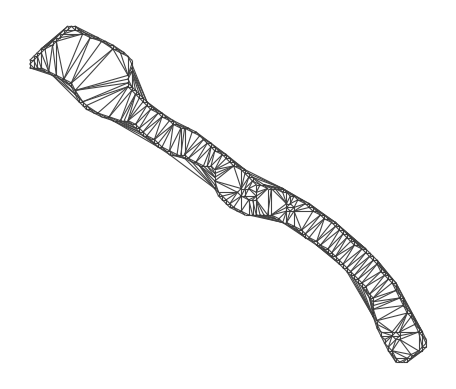

In [41]:
# edge_index = train_ds[0].edge_index.transpose(1,0)
# coord = torch.vstack([x[:,0], x[:,1]]).transpose(1,0)
import igraph as ig
import matplotlib.pyplot as plt
coordinates = np.concatenate([inner_coordinates, edge_coordinates])
edge_index = edge_index.numpy()
def create_graph(coordinates, edge_index):
    g = ig.Graph(len(coordinates))
    g.vs['x'] = coordinates[:,0].tolist()
    g.vs['y'] = coordinates[:,1].tolist()

    coords = g.layout_auto().coords
    for edge in edge_index:
        g.add_edge(edge[0], edge[1])
    g.simplify() 

    return g

f,a = plt.subplots()
g = create_graph(coordinates, edge_index)
ig.plot(
    g,
    target=a,
    vertex_size=0.04,
    vertex_color="lightblue",
    edge_width=0.8
)

plt.show()